## Do space-for-time over several chanks and map the fitted slope and intercept

In [80]:
import os
import xarray as xr
import rioxarray
from rioxarray.merge import merge_datasets, merge_arrays
import numpy as np
import geopandas as gpd
import pandas as pd
#
from sklearn.preprocessing import MinMaxScaler
#
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
#
#%matplotlib widget
#%matplotlib inline

Set the tile, orbit, and polarisation to read:
(currently for tiles within the specified test areas in Para and Rondonia)

In [2]:
#myTile = 'E066N060T3' # Rondonia
#myOrbit = 'D156' # Rondonia
#
myTile = 'E078N066T3' # Para
myOrbit = 'D039' # Para
#
myPol = 'VH'

In [3]:
# set the folter wih the output files:
data_folder = r'/project/return/Share/mm/S1_SA_TEST_UPSCALE/TILE_WISE/AOI_PA/' +  myTile 

In [4]:
# Equi7 SA wkt:
PROJ = 'PROJCS["Azimuthal_Equidistant",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.017453292519943295]],PROJECTION["Azimuthal_Equidistant"],PARAMETER["false_easting",7257179.23559],PARAMETER["false_northing",5592024.44605],PARAMETER["central_meridian",-60.5],PARAMETER["latitude_of_origin",-14.0],UNIT["Meter",1.0]]'

In [77]:
# specify variables to read from the output:
myVariable_list = ['q90_2017', 'q10_2017']
# specify the number of chunks to consider in calculation of slope and intercept:
NumChunks = 4
# specify the starting chank:
ChunkStart = 1

In [79]:
# read multiple ckunks:
ChunkDatasetList = []
# set the rwos and columns:
myCols, myRows = np.meshgrid(np.arange(ChunkStart, ChunkStart + NumChunks), np.arange(ChunkStart, ChunkStart + NumChunks)) # Para
# read each one
for myRow, myCol in zip(myRows.flatten(), myCols.flatten()):
    # set filename:
    fileName = myTile + '_' + str(myRow) + '_' + str(myCol) + '_250_' + myOrbit + '_'+ myPol + '.nc'
    folder_name = str(myRow + 1) + '_' + str(myCol + 1)
    if os.path.exists(os.path.join(data_folder, folder_name, fileName)):
        aux_ds = rioxarray.open_rasterio(os.path.join(data_folder, folder_name, fileName), variable=myVariable_list)
        # set crs:
        aux_ds.rio.write_crs(PROJ, inplace=True)
        ChunkDatasetList.append(aux_ds)      

In [82]:
# mearge chanks spatialy:
my_out = merge_datasets(ChunkDatasetList)   

Read forest age and LULC data:

In [83]:
# fileName2 = r'myforAgeLCLU_2017_2020_equi7_E066N060T3_20m.tif' # Rondonia
fileName2 = r'/home/return-mmilenkovic/mm_tools/use-case-return/input/myforAgeLCLU_2017_2020_equi7_E078N066T3_20m.tif' # Para
forAgeLULC = rioxarray.open_rasterio(fileName2, band_as_variable=True)
# convert to dataset:
forAgeLULC_ds = forAgeLULC.to_dataset('band').rename({1: 'forAge2017', 2: 'lulc2018', 3: 'lulc2019', 4: 'forAge2020', 5: 'ECO_ID'})

Chek if the coordinates match

In [84]:
set(my_out.y.values).issubset(set(forAgeLULC_ds.y.values))

False

In [85]:
set(my_out.x.values).issubset(set(forAgeLULC_ds.x.values))

False

Correct coordinates (temporary soluton!!!)

In [86]:
forAgeLULC_ds = forAgeLULC_ds.assign_coords(x=forAgeLULC_ds.x - 10 )

In [87]:
forAgeLULC_ds = forAgeLULC_ds.assign_coords(y=forAgeLULC_ds.y + 10 )

Join datasets and clip forAgeLCLU to my_out coordinates:

In [88]:
all_ds = xr.merge([my_out.isel(band=0, drop=True), forAgeLULC_ds], join='inner') 

## Add annual statistics

In [89]:
# Add the combined annual statistics:
all_ds['qDiff_2017'] = all_ds['q90_2017'] - all_ds['q10_2017']

## Convert only Forest pixels to the panda dataframe

In [90]:
# select secondary and OLD forest and convert to pandas data frame
my_df = all_ds.where((all_ds['forAge2017'] > 0) | (all_ds['forAge2017'] == 50)).to_dataframe()
# drop unneccery data:
my_df.drop(columns='spatial_ref', inplace=True)
my_df.dropna(subset=['forAge2017'], inplace=True)

## Split Old forest and Secoundary forest

In [91]:
# get secondary forest pixels
my_df_secFor = all_ds.where((all_ds['forAge2017'] > 0) & (all_ds['forAge2017'] < 50)).to_dataframe()
my_df_secFor.drop(columns='spatial_ref', inplace=True)
my_df_secFor.dropna(subset=['forAge2017'], inplace=True)
# get old forest pixels:
my_df_oldFor = all_ds.where(all_ds['forAge2017'] == 50).to_dataframe()
my_df_oldFor.drop(columns='spatial_ref', inplace=True)
my_df_oldFor.dropna(subset=['forAge2017'], inplace=True)

## Get some info about the number of avaliable secoundary forest pixels

In [92]:
# get the number of secFor pixels per age
secFor_count = my_df_secFor.groupby(by='forAge2017').count()

In [93]:
# get the total numbert of secoundary forest pixels:
NumSecFor = secFor_count.q90_2017.values.sum()
# get the average num of secFor pixels in 5 count-largest ages:
myPixNum = np.int32(np.floor(np.mean(secFor_count.q90_2017.nlargest(5).values)))
# get the average num of secFor pixels in 5 count-smallest ages:
myPixNum_smallest = np.int32(np.floor(np.mean(secFor_count.q90_2017.nsmallest(5).values)))

In [94]:
NumSecFor

165583

In [95]:
myPixNum

9216

In [96]:
myPixNum_smallest

1307

In [97]:
# get the average num of secFor pixels in the first 5 years:
np.int32(np.floor(np.mean(secFor_count[:5].q90_2017.values)))

6648

In [98]:
# get the average num of secFor pixels in the first 5 years:
np.int32(np.floor(np.mean(secFor_count.tail(5).q90_2017.values)))

4458

# Plot the data

In [99]:
# get the mean of the secFor data:
my_df_secFor = my_df_secFor.reset_index()
secFor_mean = my_df_secFor.groupby(by='forAge2017').mean()
my_secForData = secFor_mean.drop(columns=['y', 'x'])

<AxesSubplot:title={'center':'qDiff'}, xlabel='forAge2017'>

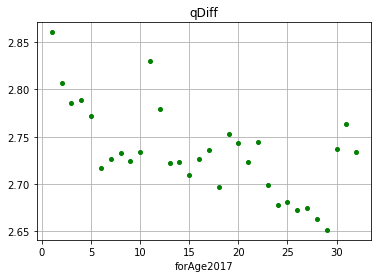

In [100]:
# add plots
my_secForData.qDiff_2017.plot(style='o', grid=True, title='qDiff', **{'markersize': 4, 'color':'green'})

## Fit the model

In [101]:
# prepare data for the MULTIVARIATE fit
X = my_secForData.reset_index()[['forAge2017']]
y = my_secForData.reset_index()[['qDiff_2017']]
# fit the model
lm = LinearRegression()
model = lm.fit(X,y)

In [102]:
model.coef_

array([[-0.00322056]])

In [103]:
model.intercept_

array([2.78718525])

In [104]:
# the R2:
model.score(X,y)

0.40065985853475583

In [106]:
# the RMSE
mean_squared_error(y, model.predict(X), squared=False)

0.03636863277623054